# Customer Revenue Prediction

## Baseline Light GBM Model
*Machine Learning Nanodegree Program | Capstone Project*

---

In this notebook I will be creating a baseline model that can be used to evaluate the performance of the Pytorch model that I will be creating as part of the project.

### Overview:
- Reading the data
- Initializing the Light GBM model
- Training the model with the train dataset
- Validating the model using the val dataset
- Predict the revenue for customer in test dataset
- Visualizing the results
- Saving the base line results to a csv 

First, import the relevant libraries into notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMModel
from os import path
from sklearn.metrics import mean_squared_error

Set the various paths for the training, validation, test files and storing the baseline results

In [3]:
data_dir = '../datasets'

if not path.exists(data_dir):
    raise Exception('{} directory not found.'.format(data_dir))

train_file = '{}/{}'.format(data_dir, 'train.zip')
print('\nTrain file: {}'.format(train_file))

val_file = '{}/{}'.format(data_dir, 'val.zip')
print('\nValidation file: {}'.format(val_file))

pred_val_file = '{}/{}'.format(data_dir, 'lgbm_pred_val.zip')
print('\nValidation Prediction file: {}'.format(pred_val_file))

test_file = '{}/{}'.format(data_dir, 'test.zip')
print('\nTest file: {}'.format(test_file))

pred_test_file = '{}/{}'.format(data_dir, 'lgbm_pred_test.zip')
print('\nTest Prediction file: {}'.format(pred_test_file))

imp_features_file = '{}/{}'.format(data_dir, 'lgbm_importances-01.png')
print('\nImportant Features file: {}'.format(imp_features_file))


Train file: ../datasets/train.zip

Validation file: ../datasets/val.zip

Validation Prediction file: ../datasets/lgbm_pred_val.zip

Test file: ../datasets/test.zip

Test Prediction file: ../datasets/lgbm_pred_test.zip

Important Features file: ../datasets/lgbm_importances-01.png


Method to load the dataset from the files

In [4]:
def load_data(zip_path):
    df = pd.read_csv(
        zip_path,
        dtype={'fullVisitorId': 'str'},
        compression='zip'
    )
    
    [rows, columns] = df.shape

    print('\nLoaded {} rows with {} columns from {}.\n'.format(
        rows, columns, zip_path
    ))
    
    return df

Load the train, validation and test datasets.

In [5]:
%%time

train_df = load_data(train_file)
val_df = load_data(val_file)
test_df = load_data(test_file)


Loaded 765707 rows with 26 columns from ../datasets/train.zip.


Loaded 137946 rows with 26 columns from ../datasets/val.zip.


Loaded 804684 rows with 25 columns from ../datasets/test.zip.

CPU times: user 8.44 s, sys: 628 ms, total: 9.06 s
Wall time: 10.3 s


In [ ]:
train_df.head()

For the LightBGM model, the labels should be separated from the features. I only need the _**fullVisitorId**_ to identify the customer and not for the training of the model. So I will drop the _**fullVisitorId**_ and _**totals.transactionRevenue**_ from the training and validation datasets and store them separately so that I can evaluate the results at later stage. From the test dataset we only need to drop _**fullVisitorId**_

In [6]:
train_id = train_df['fullVisitorId'].values
val_id = val_df['fullVisitorId'].values
test_id = test_df['fullVisitorId'].values

train_y = train_df['totals.transactionRevenue'].values
train_log_y = np.log1p(train_y)

val_y = val_df['totals.transactionRevenue'].values
val_log_y = np.log1p(val_y)

train_X = train_df.drop(['totals.transactionRevenue', 'fullVisitorId'], axis=1)
val_X = val_df.drop(['totals.transactionRevenue', 'fullVisitorId'], axis=1)
test_X = test_df.drop(['fullVisitorId'], axis=1)

In [ ]:
print('\nShape of the train dataset: {}'.format(train_X.shape))
print('\nShape of the val dataset: {}'.format(val_X.shape))
print('\nShape of the test dataset: {}\n'.format(test_X.shape))

I will be using the [LGBMModel](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMModel.html#lightgbm.LGBMModel). This funtion creates the model trains the model using the train set and predicts the transaction revenue for val and test dataset.

In [7]:
def lgbm_model(train_X, train_y, val_X, val_y, test_X):
    model = LGBMModel(
        objective='regression',
        metric='rmse',
        n_estimators=1000,
        learning_rate=0.01,
        min_child_samples=100,
        bagging_fraction=0.7,
        feature_fraction=0.5,
        bagging_freq=5,
        bagging_seed=2020
    )
    
    model = model.fit(
        train_X, 
        train_y, 
        eval_set=(val_X, val_y),
        early_stopping_rounds=100,
        verbose=100
    )
        
    pred_test_y = model.predict(
        test_X, 
        num_iteration=model.best_iteration_
    )
    pred_val_y = model.predict(
        val_X, 
        num_iteration=model.best_iteration_
    )
    
    return pred_test_y, pred_val_y, model

In [8]:
pred_test, pred_val, model = lgbm_model(train_X, train_log_y, val_X, val_log_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.8608
[200]	valid_0's rmse: 1.76686
[300]	valid_0's rmse: 1.734
[400]	valid_0's rmse: 1.7174
[500]	valid_0's rmse: 1.70967
[600]	valid_0's rmse: 1.70388
[700]	valid_0's rmse: 1.70017
[800]	valid_0's rmse: 1.69745
[900]	valid_0's rmse: 1.69625
[1000]	valid_0's rmse: 1.69537
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.69537


In order to evaluate the model, I will be calculating the Root Mean Squared Error between the actual _**total.transactionRevenue**_ and the _**predictedRevenue**_ for the validation sets

In [9]:
pred_val[pred_val < 0] = 0

pred_val_data = {
    'fullVisitorId': val_id,
    'transactionRevenue': val_y,
    'predictedRevenue': np.expm1(pred_val)
}

pred_val_df = pd.DataFrame(pred_val_data)

pred_val_df = pred_val_df.groupby('fullVisitorId')['transactionRevenue', 'predictedRevenue'].sum().reset_index()

rsme_val = np.sqrt(
    mean_squared_error(
        np.log1p(pred_val_df['transactionRevenue'].values), 
        np.log1p(pred_val_df['predictedRevenue'].values)
    )
)

print('\nRSME for validation data set: {:.6f}\n'.format(rsme_val))


RSME for validation data set: 1.718314



We will use this RSME as the baseline and compare this model with the Pytorch model that will be created to evaluate which model is better

Now lets create a base line output file for the predictions for the test dataset. 

In [10]:
pred_test[pred_test < 0] = 0

pred_test_data = {
    'fullVisitorId': test_id,
    'predictedRevenue': np.expm1(pred_test)
}

pred_test_df = pd.DataFrame(pred_test_data)

pred_test_df = pred_test_df.groupby('fullVisitorId')['predictedRevenue'].sum().reset_index()

In [11]:
pred_test_df.head()

,fullVisitorId,predictedRevenue
0,0000000259678714014,0.580006
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.015808


Write the predictions of val and test so that we can compare them with the future model

In [12]:
pred_val_df.to_csv(pred_val_file, index=False, compression='zip')
pred_test_df.to_csv(pred_test_file, index=False, compression='zip')

Visualization to see the feature importances for the model 

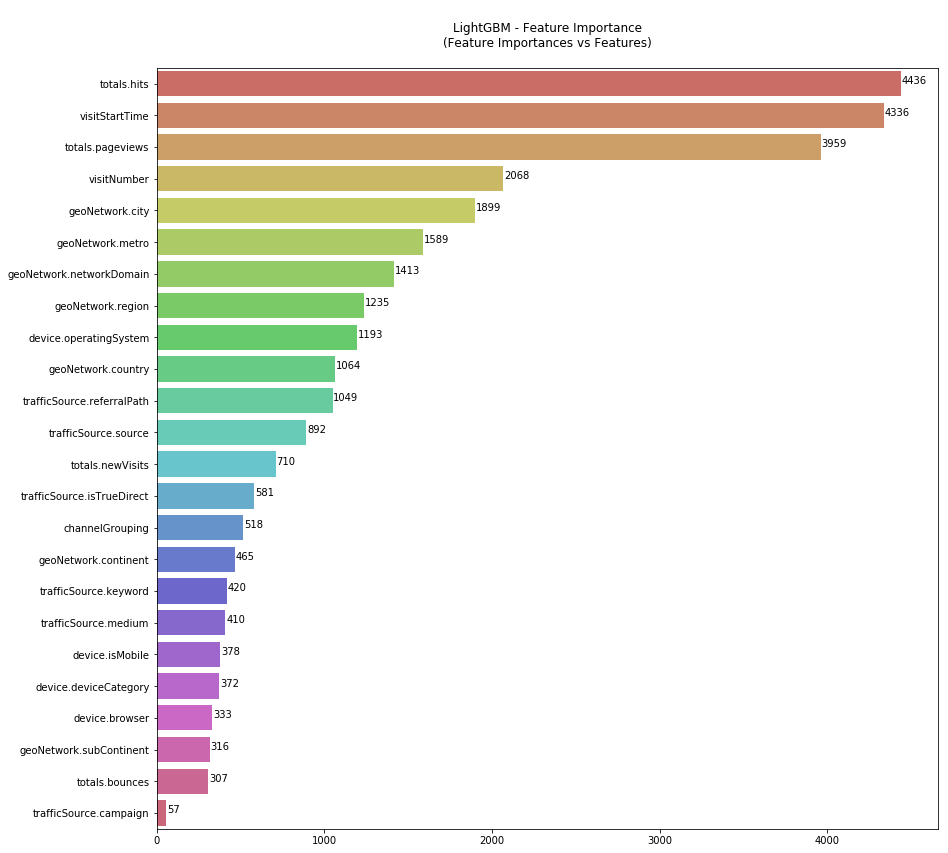

In [13]:
feature_imp = pd.DataFrame({
    'Values':model.feature_importances_,
    'Features':train_X.columns
})

feature_imp = feature_imp.sort_values(by="Values", ascending=False)

plt.figure(figsize=(14, 14))

sns_bar = sns.barplot(
    x="Values", 
    y="Features", 
    data=feature_imp,
    palette="hls",
)

for patch in sns_bar.patches:
    x = patch.get_x() + patch.get_width() + 5
    y = patch.get_y() + (patch.get_height() / 2)
    
    sns_bar.annotate(int(patch.get_width()), (x, y))

plt.title(
    "\nLightGBM - Feature Importance\n(Feature Importances vs Features)\n", 
    fontsize=12
)
plt.xlabel('') 
plt.ylabel('') 

plt.savefig(
    fname=imp_features_file,
    bbox_inches = "tight"
)

plt.show()


From the above plot, we see that **_totals.hits_**, **_visitStartTime_** and **_totals.pageviews_** are the most important features